In [17]:
import os.path as osp
import matplotlib.pylab as plt
from collections import defaultdict
from general_tools.simpletons import sort_dict_by_key
from operator import itemgetter
import numpy as np

In [18]:
%matplotlib inline

In [85]:
top_sample_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples'
top_evaluation_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/synthetic_data'
top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/plots'

In [4]:
wu_jsd_measurements = {
'chair': 0.170516077381,
'airplane': 0,
'car': 0.189045051537,
'table': 0.247168491303,
'sofa':0.181167843986
}

In [5]:
def color_of_model(name):
    colorings = {
        'gmm': 'purple',        
        'l_w_gan_small': 'blue',
        'l_w_gan_large': 'cyan',
        'l_gan_chamfer': 'green',
        'l_gan_emd': 'red',        
        'r_gan': 'yellow'
    }    
    return colorings[name]

def legend_split_name(split):
    if split == 'val':
        return 'test'
    elif split == 'test':
        return 'val'
    else:
        return split

def exp_plot_name(name):
    names = {
        'l_w_gan_small': 'l_w_emd',
        'l_w_gan_large': 'l_w_gan_large',
        'l_gan_chamfer': 'l_cham',
        'l_gan_emd': 'l_emd',        
        'r_gan': 'r_gan'
    }
    return names[name]

def exp_plot_marker(name):
    names = {
        'l_w_gan_small': 'o',
        'l_w_gan_large': '-',
        'l_gan_chamfer': '^',
        'l_gan_emd': 'v',        
        'r_gan': '*'
    }
    return names[name]



In [17]:
def stored_synthetic_samples(class_name):
    sample_dir = {'l_gan_emd': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128'),
                  'l_gan_chamfer': osp.join(top_sample_dir, 'l_gan/l_gan_' + class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128'),
                  'l_w_gan_small': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch'),
                  'l_w_gan_large': osp.join(top_sample_dir, 'l_w_gan/l_w_gan_'+ class_name + '_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch_double_neurons'),
                  'r_gan': osp.join(top_sample_dir, 'r_gan/r_gan_' + class_name + '_mlp_disc_4_fc_gen_raw_gan_2048_pts'),
                  'gmm': osp.join(top_sample_dir, 'gmm/gmm_emd_' + class_name)
                 }
    
    return sample_dir

In [18]:
def read_evaluation_file(in_file):
    all_lines = []
    res = dict()
    with open(in_file, 'r') as fin:
        for line in fin:
            l = line.rstrip()
            if len(l) > 0 and l[0] != '#':
                all_lines.append(l)
    return all_lines

def tokenize_evaluation_data(in_lines):
    current_model = None
    data_dict = defaultdict(dict)
    
    def model_name(model):
        if model.startswith('epoch'):
            return int(model[len('epoch_'):])

        elif model.endswith('gaussians'):
            tok = model.split('_')
            cov_type = tok[-3]
            n_gaussians = tok[-2]
            return cov_type + '_' + n_gaussians
            
    for line in in_lines:
        token = line.split()
        if token[0] not in ['train', 'test', 'val']:
            current_model = model_name(token[0])        # Varying epoch or n_gaussians 
        else:
            try:
                split, metric_value, metric_std = token # has - mean and std
            except:
                split, metric_value = token
                metric_std = 0
                
            metric_value = float(metric_value)
            metric_std = float(metric_std)
            data_dict[split][current_model] = (metric_value, metric_std)            
    return data_dict
    
    
def find_best_model_in_metric(in_file, sort_by='test', report=['train', 'test', 'val']):    
    all_lines = read_evaluation_file(in_file)
    data_dict = tokenize_evaluation_data(all_lines)
    stats = data_dict[sort_by]
    best_model = sorted([(stats[s][0], stats[s][1], s) for s in stats.keys()])[0]
    res = dict()
    for s in report:
        if s in data_dict:
            res[s] = (best_model[2], data_dict[s][best_model[2]])        
    return res

def collect_data_for_all_experiments(exp_dict, metric):
    data_col = dict()
    for key in exp_dict.keys(): 
        exp_name = osp.basename(exp_dict[key]) 
        in_file = osp.join(top_evaluation_dir, class_name, metric, exp_name + '.txt')
        
        all_lines = read_evaluation_file(in_file)
        data_col[key] = tokenize_evaluation_data(all_lines)
    return data_col

def stats_per_epoch_or_gaussian_type(data_dict, split='train'):
    d = data_dict[split]
    x = []
    y = []
    e = []
    for key, val in sort_dict_by_key(d):
        x.append(key)
        y.append(val[0])
        e.append(val[1])
    return x, y, e

In [11]:
exp_dict

{'gmm': '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/gmm/gmm_emd_chair',
 'l_gan_chamfer': '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/l_gan/l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_chamfer_bneck_128',
 'l_gan_emd': '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/l_gan/l_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128',
 'l_w_gan_small': '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/l_w_gan/l_w_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch',
 'r_gan': '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/r_gan_chair_mlp_disc_4_fc_gen_raw_gan_2048_pts'}

In [12]:
class_name = 'chair'
exp_dict = stored_synthetic_samples(class_name)
exp_dict.pop('l_w_gan_large', 'None')
exp_dict.pop('l_gan_chamfer', 'None')
exp_dict.pop('gmm', 'None')

'/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/gmm/gmm_emd_chair'

In [23]:
sparse_cd_mmd_data_tr = collect_data_for_all_experiments(exp_dict, 'chamfer_mmd_on_train_subset_epochs_models')
sparse_cd_mmd_data_te = collect_data_for_all_experiments(exp_dict, 'chamfer_mmd_on_test_subset_epochs_models_boost_1')

# jsd_data = collect_data_for_all_experiments(exp_dict, 'jsd_over_epochs')

# emd_mmd_sparse = collect_data_for_all_experiments(exp_dict, 'emd_mmd_sparse_epochs_3_times_100gt_vs_500synthetic')

In [19]:
# reduced_exp = exp_dict.copy()
# reduced_exp.pop('gmm', 'None')
# reduced_exp.pop('l_w_gan_large', 'None')
# emd_coverage = collect_data_for_all_experiments(reduced_exp, 'emd_coverage_over_epochs_gans_boost_test_3')
# emd_mmd_dense = collect_data_for_all_experiments(reduced_exp, 'emd_mmd_over_epochs_gans_boost_test_3')
# split = 'val'
# legend_names = []

def exp_plot_name_on_large_gap(name):
    names = {
        'l_w_gan_small': 'Latent WGAN (EMD AE)',
        'l_w_gan_large': 'l_w_gan_large',
        'l_gan_chamfer': 'Latent GAN (Chamfer AE)',
        'l_gan_emd': 'Latent GAN (EMD AE)',
        'r_gan': 'Raw GAN'
    }
    return names[name]

# fig = plt.figure(figsize=(8,5))
# ax = fig.add_subplot(111)



# for key in ['r_gan', 'l_gan_emd', 'l_gan_chamfer', 'l_w_gan_small']:    
#     _, y1, _ = stats_per_epoch_or_gaussian_type(emd_coverage[key], split)
#     _, y2, _ = stats_per_epoch_or_gaussian_type(emd_mmd_dense[key], split)    
#     y2 = np.array(y2)
#     y2 /= 2048
#     plt.plot(y1, y2, '-', linewidth=1.5, color=color_of_model(key))
#     legend_names.append(exp_plot_name_on_large_gap(key))
 
# plt.tick_params(axis='x', which='both', bottom='off', top='off')
# plt.tick_params(axis='y', which='both', left='off', right='off')
# # plt.title('MMD and Coverage via EMD (%s data)' % (legend_split_name(split)) )
# plt.ylabel('MMD', fontsize=12)
# plt.xlabel('Coverage', fontsize=12)

# plt.grid(True)
# plt.xlim(0, 0.7)

# gmm_32_mmd_score = 133.465 / float(2048)
# gmm_32_coverage_score = 0.6775
# plt.scatter(gmm_32_coverage_score, gmm_32_mmd_score, marker='+', color='purple', s=120, label='GMM')
# legend_names.append('GMM')

# leg = plt.legend(legend_names, framealpha=0.8)

# for key in reduced_exp.keys():
#     _, y1, _ = stats_per_epoch_or_gaussian_type(emd_coverage[key], split)
#     _, y2, _ = stats_per_epoch_or_gaussian_type(emd_mmd_dense[key], split)    
#     y2 = np.array(y2)
#     y2 /= 2048    
#     for m in range(len(y1)):
#         plt.plot(y1[m], y2[m], marker=exp_plot_marker(key), color=color_of_model(key), markersize=(m+1) )

# plt.tight_layout()
# plt.savefig(osp.join(top_out_dir, 'mmd_vs_coverage_emd_test_data.pdf'))

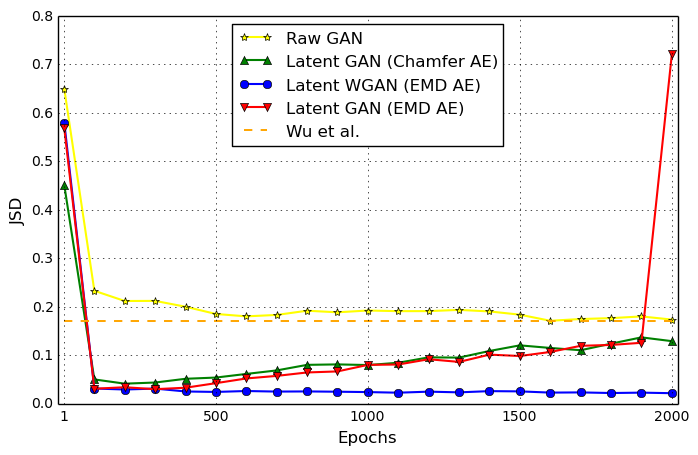

In [143]:
legend_names = []
split = 'val'

plt.figure(figsize=(8,5))

x_vals = np.arange(0, 2001, 100)
x_vals[0] = 1

for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], split)        
        x1 = np.array(x1)
        y1 = np.array(y1)
        fi = []
        for i in x_vals:
            fi.append(np.where(x1==i)[0][0])
        plt.plot(x1[fi], y1[fi], '-' + exp_plot_marker(key), linewidth=1.5, color=color_of_model(key))    
        legend_names.append(exp_plot_name_on_large_gap(key))
        
plt.xticks([1,500,1000,1500,2000], [1,500,1000,1500,2000], rotation=0)    

plt.tick_params(axis='x', which='both', bottom='off', top='off')

plt.tick_params(axis='y', which='both', left='off', right='off')

plt.xlim([-20, 2020])

plt.plot(x_vals, np.ones(len(x_vals))*wu_jsd_measurements[class_name], '--', color='orange', linewidth=1.4)

legend_names.append('Wu et al.')

plt.legend(legend_names, loc='best')

# plt.title('JSD vs epochs (%s data)' % (legend_split_name(split)) )
plt.ylabel('JSD', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True)

plt.savefig(osp.join(top_out_dir, 'mmd_cd_vs_epochs.pdf'))

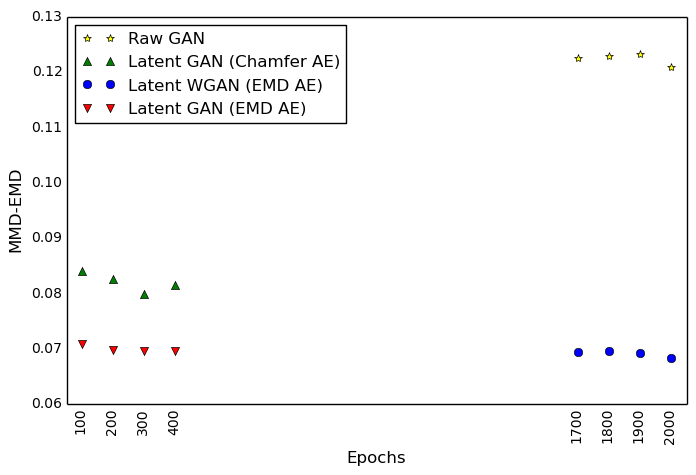

In [154]:
plt.figure(figsize=(8,5))
legend_names = []
split = 'val'
for key in exp_dict.keys():
    if 'gan' in key:
        x1, y1, _ = stats_per_epoch_or_gaussian_type(emd_mmd_sparse[key], split)
        y1 = np.array(y1)/ float(2048)
        plt.plot(x1, y1, exp_plot_marker(key), color=color_of_model(key))            
        legend_names.append(exp_plot_name_on_large_gap(key))
        
plt.xticks([100,200,300,400,1700,1800,1900,2000],[100,200,300,400,1700,1800,1900,2000], rotation='vertical')    
plt.tick_params(axis='x', which='both', bottom='off', top='off')
plt.tick_params(axis='y', which='both', left='off', right='off')
plt.legend(legend_names, loc='best')
# plt.title('MMD-EMD vs epochs (%s data)' % (legend_split_name(split)) )
plt.ylabel('MMD-EMD', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.xlim([50, 2050])
plt.savefig(osp.join(top_out_dir, 'mmd_emd_vs_epochs_sparse_100_500.pdf'))

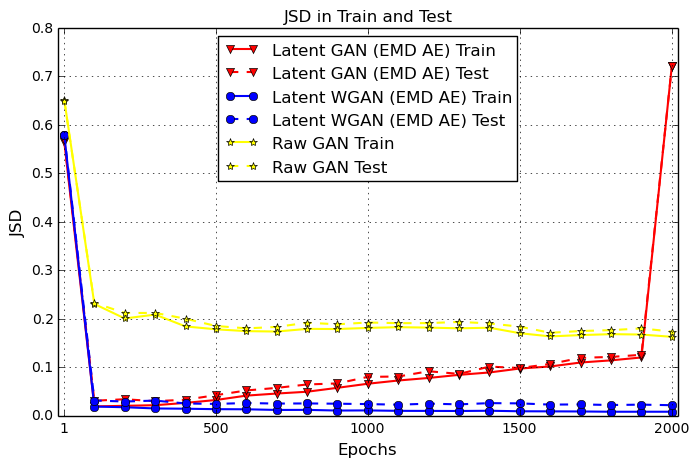

In [147]:
legend_names = []
split = 'train'
plt.figure(figsize=(8,5))
x_vals = np.arange(0, 2001, 100)
x_vals[0] = 1
                
for key in ['l_gan_emd', 'l_w_gan_small', 'r_gan']:
    x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'train')
    x1 = np.array(x1)
    y1 = np.array(y1)
    fi = []
    for i in x_vals:
        fi.append(np.where(x1==i)[0][0])
            
    plt.plot(x1[fi], y1[fi], '-' + exp_plot_marker(key), linewidth=1.5, color=color_of_model(key))
    legend_names.append(exp_plot_name_on_large_gap(key) + ' Train')
    
    x1, y1, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'val')
    x1 = np.array(x1)
    y1 = np.array(y1)
    plt.plot(x1[fi], y1[fi], '--' + exp_plot_marker(key), linewidth=1.5, color=color_of_model(key))
    legend_names.append(exp_plot_name_on_large_gap(key) + ' Test')

plt.xlim([-20, 2020])
plt.xticks([1,500,1000,1500,2000], [1,500,1000,1500,2000], rotation=0)    
        
plt.grid(True)        
plt.legend(legend_names, loc='best')
plt.title('JSD in Train and Test')
plt.ylabel('JSD', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

plt.savefig(osp.join(top_out_dir, 'jsd_train_vs_test.pdf'))

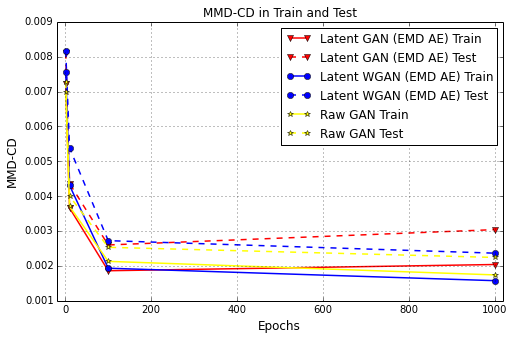

In [25]:

sparse_cd_mmd_data_tr = collect_data_for_all_experiments(exp_dict, 'chamfer_mmd_on_train_subset_epochs_models')
sparse_cd_mmd_data_te = collect_data_for_all_experiments(exp_dict, 'chamfer_mmd_on_test_subset_epochs_models_boost_1')
top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/'

legend_names = []
split = 'train'
plt.figure(figsize=(8,5))
x_vals = [1, 10, 100, 1000]

                
for key in ['l_gan_emd', 'l_w_gan_small', 'r_gan']:
    x1, y1, _ = stats_per_epoch_or_gaussian_type(sparse_cd_mmd_data_tr[key], 'train')
    x1 = np.array(x1)
    y1 = np.array(y1)
    fi = []
    for i in x_vals:
        fi.append(np.where(x1==i)[0][0])
            
    plt.plot(x1[fi], y1[fi], '-' + exp_plot_marker(key), linewidth=1.5, color=color_of_model(key))
    legend_names.append(exp_plot_name_on_large_gap(key) + ' Train')
    
    x1, y1, _ = stats_per_epoch_or_gaussian_type(sparse_cd_mmd_data_te[key], 'val')
    x1 = np.array(x1)
    y1 = np.array(y1)
    plt.plot(x1[fi], y1[fi], '--' + exp_plot_marker(key), linewidth=1.5, color=color_of_model(key))
    legend_names.append(exp_plot_name_on_large_gap(key) + ' Test')

plt.xlim([-20, 1020])
# plt.xticks([1,500,1000,1500,2000], [1,500,1000,1500,2000], rotation=0)    
        
plt.grid(True)        
plt.legend(legend_names, loc='best')
plt.title('MMD-CD in Train and Test')
plt.ylabel('MMD-CD', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

plt.savefig(osp.join(top_out_dir, 'mmd_cd_train_vs_test_boost_3.pdf'))

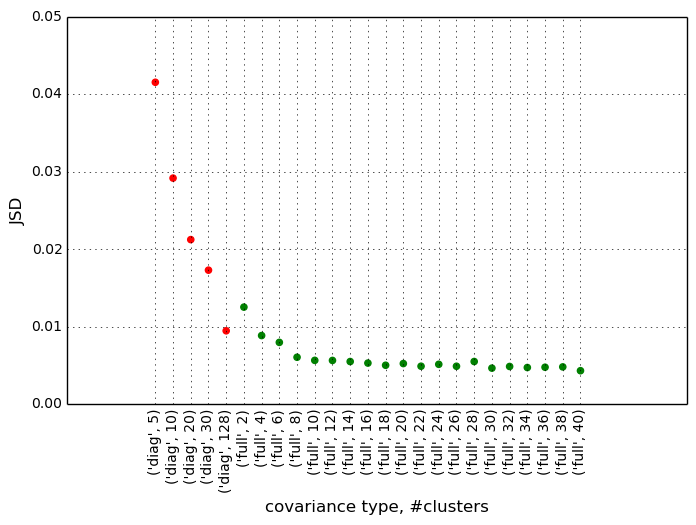

In [11]:
plt.figure(figsize=(8,5))
legend_names = []
split = 'train'
for key in ['gmm']:
    labels, y, _ = stats_per_epoch_or_gaussian_type(jsd_data[key], 'train')    
    labels_ = [l.split('_')for l in labels]
    labels_ = [(l[0], int(l[1])) for l in labels_]
    arg_labels = sorted(enumerate(labels_), key=itemgetter(1))
    labels = [l[1] for l in arg_labels]
    arg_y = [l[0] for l in arg_labels]
    x = np.arange(len(labels))
    
    plt.scatter(x[:5], np.array(y)[arg_y[:5]], color='red')
    plt.scatter(x[5:], np.array(y)[arg_y[5:]], color='green')
    
    plt.xticks(x, labels, rotation='vertical')    
#     plt.title('JSD of GMMs')
    plt.ylabel('JSD', fontsize=12)
    plt.xlabel('covariance type, #clusters', fontsize=12)    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
plt.grid(True)            
plt.savefig(osp.join(top_out_dir, 'jsd_of_gmms.pdf'))

In [18]:
in_f = osp.join(top_evaluation_dir, class_name, 'sorted_by/by_mmd/emd_mmd_on_test_sort_by_mmd_chamfer_boost_3.txt')

def read_file_with_repeated_measurements(in_file):
    all_lines = read_evaluation_file(in_file)    
    current_model = None
    data_dict = defaultdict(list)
    for line in all_lines:
        if line.startswith('epoch') or line.startswith('bneck'):
            continue
        token = line.split()
        if token[0] not in ['train', 'test', 'val']:
            current_model = token[0]
        else:
            metric_value = float(token[1])
            data_dict[current_model].append(metric_value)
    
    for key in data_dict:
        data_dict[key] = np.mean(data_dict[key])
        print key, '%f' % (np.mean(data_dict[key])/float(2048), )
    
read_file_with_repeated_measurements(in_f)

l_w_gan_small 0.066408
l_gan_emd 0.068469
r_gan 0.126584
gmm 0.064661
l_gan_chamfer 0.080023


In [13]:
jsd_data

{'gmm': defaultdict(dict,
             {'test': {'diag_10': (0.0352762419246, 0.0),
               'diag_128': (0.015353309103, 0.0),
               'diag_20': (0.0283783834762, 0.0),
               'diag_30': (0.0271064714509, 0.0),
               'diag_5': (0.0473351419371, 0.0),
               'full_10': (0.0133000783658, 0.0),
               'full_12': (0.0140529637012, 0.0),
               'full_14': (0.0127658946513, 0.0),
               'full_16': (0.0139625920975, 0.0),
               'full_18': (0.0125019263628, 0.0),
               'full_2': (0.0175675662382, 0.0),
               'full_20': (0.0139445716387, 0.0),
               'full_22': (0.0122747255878, 0.0),
               'full_24': (0.0132719637427, 0.0),
               'full_26': (0.0122144216786, 0.0),
               'full_28': (0.0156779392539, 0.0),
               'full_30': (0.0132465520322, 0.0),
               'full_32': (0.0116601563822, 0.0),
               'full_34': (0.0117735282327, 0.0),
               'fu

In [19]:


'mmd_chamfer_all_gt_boosted_5_time_synthetic'
# 'mmd_emd_sparse_3times_100gt_vs_500synthetic'
# 'jsd'

sort_by_metric = 'jsd_over_epochs'
report_metric_at = ['train', 'test', 'val']
legend_names = []

for key in exp_dict.keys():
    print key
    exp_name = osp.basename(exp_dict[key]) 
    in_file = osp.join(top_evaluation_dir, class_name, sort_by_metric, exp_name + '.txt')    
    best_model = find_best_model_in_metric(in_file, sort_by='test', report=report_metric_at)
#     print best_model
    best_id = best_model['test'][0]
    print 'best epoch', best_id
    for split in ['train']:
        print sort_by_metric, split, '%f' %(best_model[split][1][0], )
        
#         if split in boost_5_data[key] and not 'mmd' in sort_by_metric:
#             st = boost_5_data[key][split][best_id]
#             print 'cd_boost_5 %s %f %f' % (split, st[0], st[1])
        
#         if split in emd_100_500_data[key]:
#             st = emd_100_500_data[key][split][best_id]
#             print 'emd_100_500 %s %f %f' %(split, st[0] / float(2048), st[1] / float(2048))
        
        
# # #         if split in jsd_data[key]:
# # #             st = jsd_data[key][split][best_id]
# # #             print 'jsd %.4f' %(st[0])

gmm
best epoch full_32
jsd_over_epochs train 0.004899
r_gan
best epoch 1700
jsd_over_epochs train 0.166009
l_gan_chamfer
best epoch 300
jsd_over_epochs train 0.037284
l_w_gan_small
best epoch 1800
jsd_over_epochs train 0.007762
l_gan_emd
best epoch 100
jsd_over_epochs train 0.018802


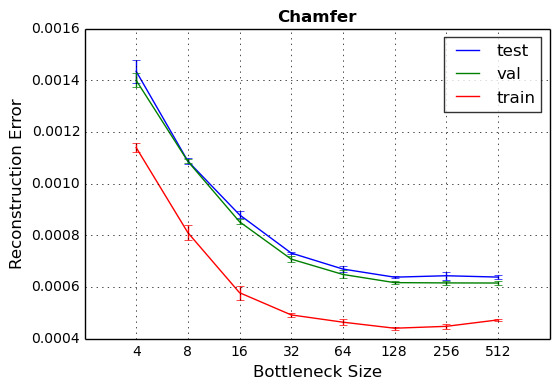

In [101]:
# Plot of Effect-of-bottleneck size

from collections import defaultdict
from general_tools.simpletons import sort_dict_by_key

versions = ['v0', 'v1', 'v2']
loss = 'EMD' # CHANGE to Chamfer 
bneck_effect = defaultdict(list)
for v in versions:
    in_f = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/effect_of_bneck_size/' + loss.lower() + '_' + v + '.txt'
    with open (in_f, 'r') as fin:
        for line in fin:
            tokens = line.split()
            bneck_effect[int(tokens[0])].append(
                np.array([float(tokens[1]), float(tokens[2]), float(tokens[3]), float(tokens[4])]))
                          
                

split_idx = [0, 1, 2]
if loss.lower() == 'emd':
    split_idx = [1, 0, 2]
    
for label, s_id in zip(['test', 'val', 'train'], split_idx):
    averaged_data = [] 
    sigmas = []    
    xticks = []
    for b in sort_dict_by_key(bneck_effect):    
        xticks.append(b[0])
        
        val = np.vstack(b[1])
        if loss.lower() == 'emd':
            val /= float(2048)

        mu = np.mean(val, axis=0)
        sigma = np.std(val, axis=0)
        
        
        averaged_data.append(mu[s_id])
        sigmas.append(sigma[s_id])
    plt.errorbar(range(len(averaged_data)), averaged_data, yerr=sigmas)    
    plt.legend(['test', 'val', 'train'], loc='best',  framealpha=0.8)
    plt.ylabel('Reconstruction Error',  fontsize=12)
    plt.xlabel('Bottleneck Size',  fontsize=12)    
    plt.xticks(range(len(xticks)), xticks, rotation='horizontal')

    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    plt.title(loss, fontweight='bold', fontsize=12)
    plt.xlim([-1, 8])
    plt.grid(True) 
    plt.savefig
    plt.savefig(osp.join(top_out_dir, 'effect_of_bneck_' + loss + '.pdf'))